In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from pathlib import Path
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.linear_model import LinearRegression
import seaborn as sns
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from scipy.signal import periodogram
import datetime as dt


In [2]:
import os
print(os.getcwd())
pd.set_option('mode.chained_assignment', None)


C:\Users\Lena\Dokumente\GitHub\DataLiteracy


In [3]:
path = "Daten/data.csv"
df =  pd.read_csv(path,header=1, sep=";", names=['date','Tunnel','Steinlach','Hirschau'], parse_dates=['date']).dropna()
df['date']=pd.to_datetime(df['date']).dt.date
df=df.groupby(['date']).sum()


In [4]:
df_weeks = df.copy()
df_weeks.is_copy = True

weeks = pd.date_range('2018-01-01', '2022-11-27', freq='W').to_numpy()
weeks= np.repeat(weeks, 7)

df_weeks['weekdate']= weeks.tolist()
df_weeks['weekdate']=pd.to_datetime(df_weeks['weekdate']).dt.date
df_weeks = df_weeks.groupby('weekdate').sum()

df_weeks.index = pd.to_datetime(df_weeks.index)
df_weeks['week'] = df_weeks.index.isocalendar().week
df_weeks['year'] = df_weeks.index.year
df_weeks['total'] = df_weeks['Tunnel'] + df_weeks['Steinlach'] + df_weeks['Hirschau']




In [5]:
#train dataframes
#for forecast
weeks_trainval = df_weeks.copy()
weeks_trainval.is_copy = True

weeks_to_drop = df_weeks[df_weeks['year'] == 2022].index
weeks_trainval = weeks_trainval.drop(weeks_to_drop)

weeks_trainval.index.freq = 'W'

#for parameter finding
weeks_train = weeks_trainval.copy()
weeks_train.is_copy = True

weeks_to_drop = df_weeks[df_weeks['year'] == 2021].index
weeks_train = weeks_train.drop(weeks_to_drop)

weeks_train.index.freq = 'W'

#validation dataframe
weeks_validate = df_weeks.copy()
weeks_validate.is_copy = True

weeks_to_drop = df_weeks[df_weeks['year'] != 2021].index
weeks_validate = weeks_validate.drop(weeks_to_drop)

weeks_validate.index.freq = 'W'


#test dataframe
weeks_test = df_weeks.copy()
weeks_test.is_copy = True

weeks_to_drop = df_weeks[df_weeks['year'] != 2022].index
weeks_test = weeks_test.drop(weeks_to_drop)

print(len(weeks_trainval))
print(len(weeks_train))
print(len(weeks_validate))
print(len(weeks_test))

208
156
52
48


In [6]:
#######for loop through all numbers of fourier terms to check for residuals 

max_fourier = 52

residuals_train = np.zeros(max_fourier)
residuals_test = np.zeros(max_fourier)

for i in range(max_fourier):
    
    fourier = CalendarFourier(freq="A", order=i+1)
    
    
    dp = DeterministicProcess(
        index=weeks_train.index,
        constant=True,               # dummy feature for bias (y-intercept)
        order=1,                     # trend (order 1 means linear)
        seasonal=False,               # weekly seasonality (indicators)
        additional_terms=[fourier],  # annual seasonality (fourier)
        drop=True,                   # drop terms to avoid collinearity
    )

    X = dp.in_sample()  # create features for dates in tunnel.index
    X_fore = dp.out_of_sample(steps=len(weeks_validate))
    
    
    y = weeks_train['total']
    y_test = weeks_validate['total']
    model = LinearRegression(fit_intercept=False)
    _ = model.fit(X, y)
        
    y_pred = model.predict(X)
    y_fore = model.predict(X_fore)
        
    train_res = np.abs(y - y_pred)
    test_res = np.abs(y_test - y_fore)
            
    residuals_train[i] = sum(train_res)/len(train_res)
    residuals_test[i] = sum(test_res)/len(test_res)
                

fourierno = np.argmin(residuals_test)+1

In [8]:
ax = plt.axes()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(range(1,max_fourier+1), residuals_train, color='cornflowerblue', label='train set')
plt.plot(range(1,max_fourier+1), residuals_test, color='lightblue', label='validation set')
plt.axvline(fourierno, color='lightblue', label='minimum for '+str(fourierno)+'\nfourier pairs', linestyle='--')
plt.xlabel('number of fourier pairs')
plt.ylabel('mean residuals')
    
plt.legend()
plt.show()

In [9]:
fourier = CalendarFourier(freq="A", order=28)

In [10]:
##create training values
dp = DeterministicProcess(
    index=weeks_trainval.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=False,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

X_test = dp.out_of_sample(steps=len(weeks_test))

In [11]:
X

const  trend  sin(1,freq=A-DEC)  cos(1,freq=A-DEC)  \
weekdate                                                         
2018-01-07    1.0    1.0           0.103102           0.994671   
2018-01-14    1.0    2.0           0.221922           0.975065   
2018-01-21    1.0    3.0           0.337523           0.941317   
2018-01-28    1.0    4.0           0.448229           0.893919   
2018-02-04    1.0    5.0           0.552435           0.833556   
...           ...    ...                ...                ...   
2021-11-28    1.0  204.0          -0.552435           0.833556   
2021-12-05    1.0  205.0          -0.448229           0.893919   
2021-12-12    1.0  206.0          -0.337523           0.941317   
2021-12-19    1.0  207.0          -0.221922           0.975065   
2021-12-26    1.0  208.0          -0.103102           0.994671   

            sin(2,freq=A-DEC)  cos(2,freq=A-DEC)  sin(3,freq=A-DEC)  \
weekdate                                                              
2018-01-07           0.205104           0.978740           0.304921   
2018-01-14           0.432776           0.901502           0.622047   
2018-01-21           0.635432           0.772157           0.858764   
2018-01-28           0.801361           0.598181           0.984474   
2018-02-04           0.920971           0.389630           0.982927   
...                       ...                ...                ...   
2021-11-28          -0.920971           0.389630          -0.982927   
2021-12-05          -0.801361           0.598181          -0.984474   
2021-12-12          -0.635432           0.772157          -0.858764   
2021-12-19          -0.432776           0.901502          -0.622047   
2021-12-26          -0.205104           0.978740          -0.304921   

            cos(3,freq=A-DEC)  sin(4,freq=A-DEC)  cos(4,freq=A-DEC)  ...  \
weekdate                                                             ...   
2018-01-07           0.952378           0.401488           0.915864  ...   
2018-01-14           0.782980           0.780296           0.625411  ...   
2018-01-21           0.512371           0.981306           0.192452  ...   
2018-01-28           0.175531           0.958718          -0.284359  ...   
2018-02-04          -0.183998           0.717677          -0.696376  ...   
...                       ...                ...                ...  ...   
2021-11-28          -0.183998          -0.717677          -0.696376  ...   
2021-12-05           0.175531          -0.958718          -0.284359  ...   
2021-12-12           0.512371          -0.981306           0.192452  ...   
2021-12-19           0.782980          -0.780296           0.625411  ...   
2021-12-26           0.952378          -0.401488           0.915864  ...   

            sin(24,freq=A-DEC)  cos(24,freq=A-DEC)  sin(25,freq=A-DEC)  \
weekdate                                                                 
2018-01-07            0.615285           -0.788305            0.530730   
2018-01-14           -0.790946            0.611886           -0.635432   
2018-01-21            0.917584           -0.397543            0.729558   
2018-01-28           -0.987349            0.158559           -0.811539   
2018-02-04            0.995919            0.090252            0.880012   
...                        ...                 ...                 ...   
2021-11-28           -0.995919            0.090252           -0.880012   
2021-12-05            0.987349            0.158559            0.811539   
2021-12-12           -0.917584           -0.397543           -0.729558   
2021-12-19            0.790946            0.611886            0.635432   
2021-12-26           -0.615285           -0.788305           -0.530730   

            cos(25,freq=A-DEC)  sin(26,freq=A-DEC)  cos(26,freq=A-DEC)  \
weekdate                                                                 
2018-01-07           -0.847541            0.440519           -0.897743   
2018-01-14            0.772157           -0.448229     

In [12]:
#fit linear regression model
y_train = weeks_trainval['total']
y_test_all = weeks_test['total']
model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y_train)

#compute prediction for train and test sets
y_train_pred = pd.Series(model.predict(X), index=y_train.index) 
y_pred = pd.Series(model.predict(X_test), index=X_test.index)

#split test forcast into before and after closing date
test_start_date = "2022-01-02"
closing_date = "2022-04-03"
after_closing_date = "2022-04-10"
test_end_date = "2022-11-27"

y_control = weeks_test['total'].filter(items=list(pd.date_range(test_start_date, closing_date, freq='W')), axis=0)
y_control_pred = y_pred.filter(pd.date_range(test_start_date, closing_date, freq='W'))

y_test = weeks_test['total'].filter(items=list(pd.date_range(after_closing_date, test_end_date, freq='W')), axis=0)
y_test_pred = y_test_pred = y_pred.filter(pd.date_range(after_closing_date, test_end_date, freq='W'))


In [13]:
#compute residuals
resid_train = y_train.values - y_train_pred.values
resid_control = y_control.values - y_control_pred.values
resid_test = y_test.values - y_test_pred.values


In [14]:
#define color palette for plots
col_train = 'dodgerblue'
col_control = 'orange'
col_test = 'orangered'

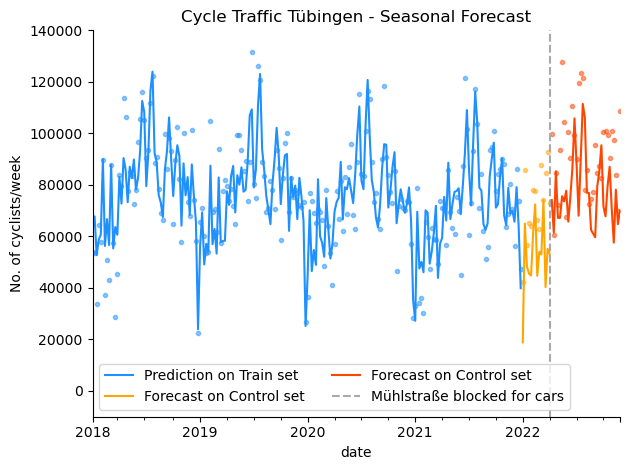

In [15]:
#prediciton curve plot
fig, a = plt.subplots(1,1)
tit="Cycle Traffic Tübingen - Seasonal Forecast"
upper_lim = 140000
lower_lim = -10000
#plot actual datapoints
a = y_train.plot(color=col_train, style='.', label='_Train data', title=tit, alpha = 0.5)
a = y_control.plot(color=col_control, style='.', label='_Control data', alpha = 0.5)
a = y_test.plot(color=col_test, style='.', label='_Test data', alpha = 0.5)

a = y_train_pred.plot(ax=a, label="Prediction on Train set", color=col_train)
a = y_control_pred.plot(ax=a, label="Forecast on Control set", color=col_control)
a = y_test_pred.plot(ax=a, label="Forecast on Control set", color=col_test)

a.vlines(closing_date, lower_lim, upper_lim, color="darkgrey", linestyle="dashed", label="Mühlstraße blocked for cars")    

a.spines['top'].set_visible(False)
a.spines['right'].set_visible(False)
a.grid(False)
plt.xlabel("date")
plt.ylabel("No. of cyclists/week")
plt.ylim(lower_lim, upper_lim)
_ = a.legend(ncol=2, loc="lower left")
plt.tight_layout()
plt.savefig(f"tuebingen_pred_fourierno{fourierno}.png",dpi=600)
plt.show()

In [54]:
#function to plot residual histograms
def plot_residuals(residuals, name, set_type, label, colors, ymax):
    # histogram
    ax = plt.axes()
    
    i = 0
    for resid, col in zip(residuals, colors):
        counts, bins = np.histogram(resid, bins = 12)
        
        #fig, ax = plt.subplots()
        if i==1:
            plt.hist(bins[:-1], bins, weights=counts, color = 'white', stacked = True)
        plt.hist(bins[:-1], bins, weights=counts, color = col, stacked = True, alpha = 0.6)
        
        plt.ylim([0, ymax])
        plt.ylabel('count')
        plt.yticks() 
        plt.xlabel('residuals')
        plt.xticks() 
        plt.vlines(np.mean(resid), 0, ymax, color = col, label=f'{label[i]} mean: {round(np.mean(resid))}')
        
        i +=1
        # remove grid and axes
    plt.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(name)
    plt.legend(loc='upper left')
    plt.savefig(f"residual_histogram{name}.png",dpi=600)
    plt.show()

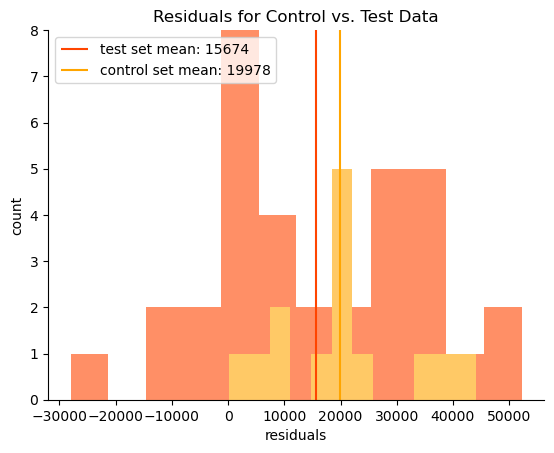

In [55]:
plot_residuals([resid_train], 'Residuals for Train Data', 'trainset', ['train set'], [col_train], 50)
plot_residuals([resid_test, resid_control], 'Residuals for Control vs. Test Data', 'control vs test', ['test set', 'control set'], [col_test, col_control], 8)

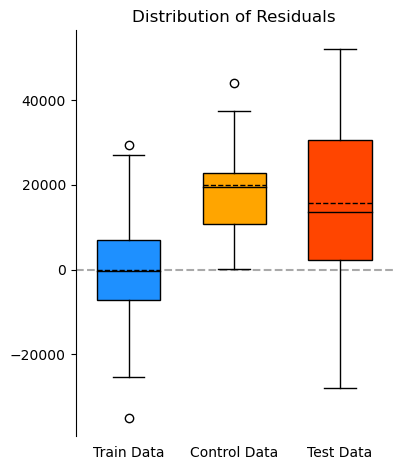

In [56]:
fig, ax = plt.subplots()
columns = [resid_train, resid_control, resid_test]

ax.hlines(0, 0.5, 3.5, color="darkgrey", linestyle="dashed", label="_zero")    

box = ax.boxplot(columns, labels=['Train Data', 'Control Data', 'Test Data'], patch_artist=True, meanline=True, showmeans=True, medianprops={'color':'black'}, meanprops={'color':'black', 'linestyle':'--'}, widths=0.6)

for patch, color in zip(box['boxes'], [col_train, col_control, col_test]):
    patch.set_facecolor(color)
    


ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off

ax.set_aspect(0.00004)

ax.set_title("Distribution of Residuals")
plt.tight_layout()
plt.savefig("residuals_boxplot.png",dpi=600)
plt.show()

